<a href="https://colab.research.google.com/github/kevinBonifacio/RAWG_API_Project/blob/main/RAWG_Video_Games_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection

In [1]:
from google.colab import files
uploaded = files.upload()


Saving elite-campus-472819-d1-78a4c13a30a7.json to elite-campus-472819-d1-78a4c13a30a7.json


In [2]:
import requests
import pandas as pd
import os
from google.cloud import storage
from datetime import datetime

# Google Cloud setup
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "elite-campus-472819-d1-78a4c13a30a7.json" # Replace with the JSON key

# Connect to your bucket
client = storage.Client()
bucket_name = "rawg-api-storage-bonifacio"  # replace with your bucket name
bucket = client.get_bucket(bucket_name)

API_KEY = "58b7fd26ecc4478b988134c6031c23eb"
BASE_URL = "https://api.rawg.io/api/games"

all_games = []

# Fetch 25 pages of 40 games
for page in range(1, 26):
    params = {
        "key": API_KEY,
        "page_size": 40,
        "page": page,
        "ordering": "-added",
    }

    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        data = response.json()
        games = data.get("results", [])
        all_games.extend(games)  # <-- this line is essential
        print(f"Page {page} fetched: {len(games)} games")
    else:
        print("Error on page", page, response.status_code, response.text)

# Convert to DataFrame
df = pd.DataFrame([{
    "Name": game.get("name", "Unknown"),
    "Released": game.get("released", "Unknown"),
    "Rating": game.get("rating", None),
    "Genres": [genre.get("name", "Unknown") for genre in game.get("genres") or [] if genre],
    "Platforms": [p.get("platform", {}).get("name", "Unknown") for p in (game.get("platforms") or []) if p],
    "Added_Count": game.get("added", 0)
} for game in all_games])

print(f"Total games collected: {len(df)}")
display(df.head())

# Save CSV
today = datetime.today().strftime('%Y-%m-%d')
filename = f"rawg_{today}.csv"
df.to_csv(filename, index=False)

# Upload to Google Cloud
blob = bucket.blob(filename)
blob.upload_from_filename(filename)
print(f"File {filename} uploaded to Google Cloud Storage successfully!")

Page 1 fetched: 40 games
Page 2 fetched: 40 games
Page 3 fetched: 40 games
Page 4 fetched: 40 games
Page 5 fetched: 40 games
Page 6 fetched: 40 games
Page 7 fetched: 40 games
Page 8 fetched: 40 games
Page 9 fetched: 40 games
Page 10 fetched: 40 games
Page 11 fetched: 40 games
Page 12 fetched: 40 games
Page 13 fetched: 40 games
Page 14 fetched: 40 games
Page 15 fetched: 40 games
Page 16 fetched: 40 games
Page 17 fetched: 40 games
Page 18 fetched: 40 games
Page 19 fetched: 40 games
Page 20 fetched: 40 games
Page 21 fetched: 40 games
Page 22 fetched: 40 games
Page 23 fetched: 40 games
Page 24 fetched: 40 games
Page 25 fetched: 40 games
Total games collected: 1000


,Name,Released,Rating,Genres,Platforms,Added_Count
0,Grand Theft Auto V,2013-09-17,4.47,[Action],"[PC, PlayStation 5, Xbox Series S/X, PlayStati...",22243
1,The Witcher 3: Wild Hunt,2015-05-18,4.64,"[Action, RPG]","[PlayStation 5, Xbox Series S/X, macOS, PlaySt...",21913
2,Portal 2,2011-04-18,4.58,"[Shooter, Puzzle]","[PlayStation 3, PC, Xbox 360, Linux, macOS, Xb...",20699
3,Counter-Strike: Global Offensive,2012-08-21,3.57,[Shooter],"[PC, Linux, Xbox 360, PlayStation 3]",18313
4,Tomb Raider (2013),2013-03-05,4.06,[Action],"[PlayStation 3, Xbox 360, macOS, PC, Xbox One,...",17684


File rawg_2025-09-28.csv uploaded to Google Cloud Storage successfully!


# Data analysis


In [3]:
from google.cloud import storage
import pandas as pd
import os
import ast

client = storage.Client()
bucket_name = "rawg-api-storage-bonifacio"
bucket = client.get_bucket(bucket_name)

# List CSVs sorted by date
blobs = bucket.list_blobs()
csv_files = sorted([blob.name for blob in blobs if blob.name.endswith(".csv")])

all_dfs = []

for csv_file in csv_files:
    local_file = csv_file.replace("/", "_")
    blob = bucket.blob(csv_file)
    blob.download_to_filename(local_file)

    df = pd.read_csv(local_file)
    df['Genres'] = df['Genres'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
    df['Platforms'] = df['Platforms'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

    # extract date from filename
    import re
    match = re.search(r"(\d{4}-\d{2}-\d{2})", csv_file)
    df['date'] = match.group(1) if match else "unknown"

    all_dfs.append(df)
    os.remove(local_file)


# Genre Popularity

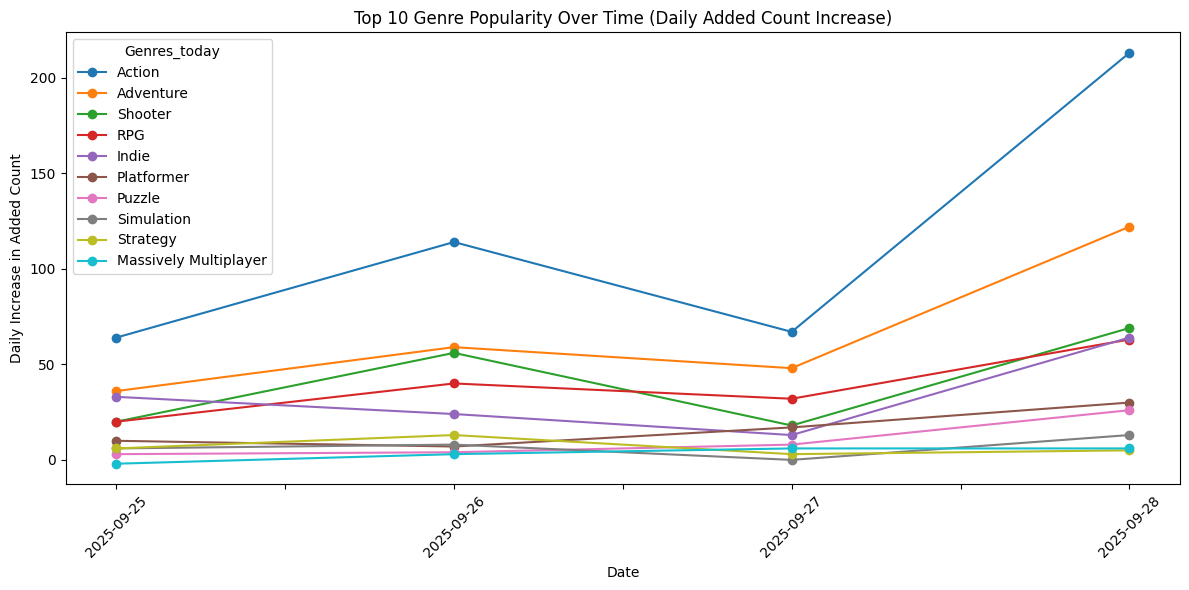

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure all_dfs is sorted by date
all_dfs = sorted(all_dfs, key=lambda df: df["date"].iloc[0])

genre_diffs = []

for i in range(1, len(all_dfs)):
    today = all_dfs[i]
    yesterday = all_dfs[i-1]

    merged = pd.merge(
        today[["Name", "Added_Count", "Genres"]],
        yesterday[["Name", "Added_Count", "Genres"]],
        on="Name",
        suffixes=("_today", "_yesterday"),
        how="inner"
    )

    # daily difference
    merged["Added_Diff"] = merged["Added_Count_today"] - merged["Added_Count_yesterday"]

    # keep today's genres
    merged = merged[["Name", "Genres_today", "Added_Diff"]]

    # explode genres
    exploded = merged.explode("Genres_today")

    # aggregate by genre
    genre_day = exploded.groupby("Genres_today")["Added_Diff"].sum().reset_index()
    genre_day["date"] = today["date"].iloc[0]

    genre_diffs.append(genre_day)

# Combine all daily genre differences
genre_trends = pd.concat(genre_diffs)

# Pivot so genres become columns
pivot_df = genre_trends.pivot(index="date", columns="Genres_today", values="Added_Diff").fillna(0)

# Pick top 10 genres overall
top_genres = pivot_df.sum().sort_values(ascending=False).head(10).index

# Plot
pivot_df[top_genres].plot(kind="line", marker="o", figsize=(12,6))
plt.title("Top 10 Genre Popularity Over Time (Daily Added Count Increase)")
plt.xlabel("Date")
plt.ylabel("Daily Increase in Added Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Platform Popularity

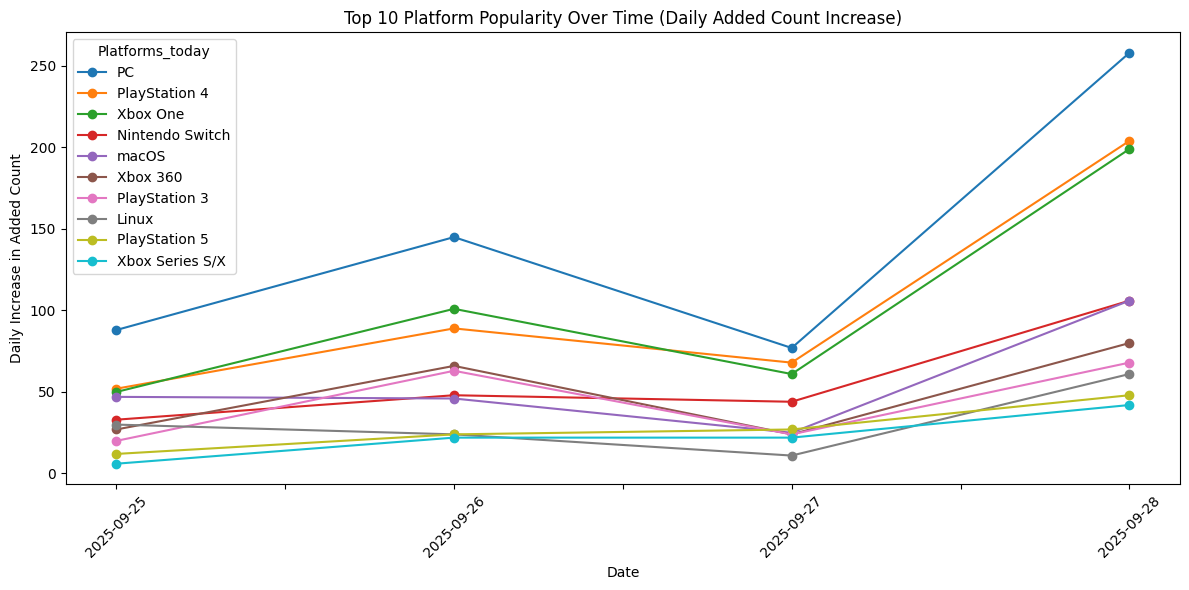

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure all_dfs is sorted by date
all_dfs = sorted(all_dfs, key=lambda df: df["date"].iloc[0])

platform_diffs = []

for i in range(1, len(all_dfs)):
    today = all_dfs[i]
    yesterday = all_dfs[i-1]

    merged = pd.merge(
        today[["Name", "Added_Count", "Platforms"]],
        yesterday[["Name", "Added_Count", "Platforms"]],
        on="Name",
        suffixes=("_today", "_yesterday"),
        how="inner"
    )

    # daily difference
    merged["Added_Diff"] = merged["Added_Count_today"] - merged["Added_Count_yesterday"]

    # keep today's platforms
    merged = merged[["Name", "Platforms_today", "Added_Diff"]]

    # explode platforms
    exploded = merged.explode("Platforms_today")

    # aggregate by platform
    platform_day = exploded.groupby("Platforms_today")["Added_Diff"].sum().reset_index()
    platform_day["date"] = today["date"].iloc[0]

    platform_diffs.append(platform_day)

# Combine all daily platform differences
platform_trends = pd.concat(platform_diffs)

# Pivot so platforms become columns
pivot_df = platform_trends.pivot(index="date", columns="Platforms_today", values="Added_Diff").fillna(0)

# Pick top 10 platforms overall
top_platforms = pivot_df.sum().sort_values(ascending=False).head(10).index

# Plot
pivot_df[top_platforms].plot(kind="line", marker="o", figsize=(12,6))
plt.title("Top 10 Platform Popularity Over Time (Daily Added Count Increase)")
plt.xlabel("Date")
plt.ylabel("Daily Increase in Added Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Genre vs Platform (Cross Analysis)

Each cell represents the total daily increase in “Added_Count” for games of that genre on that platform across all days you analyzed.

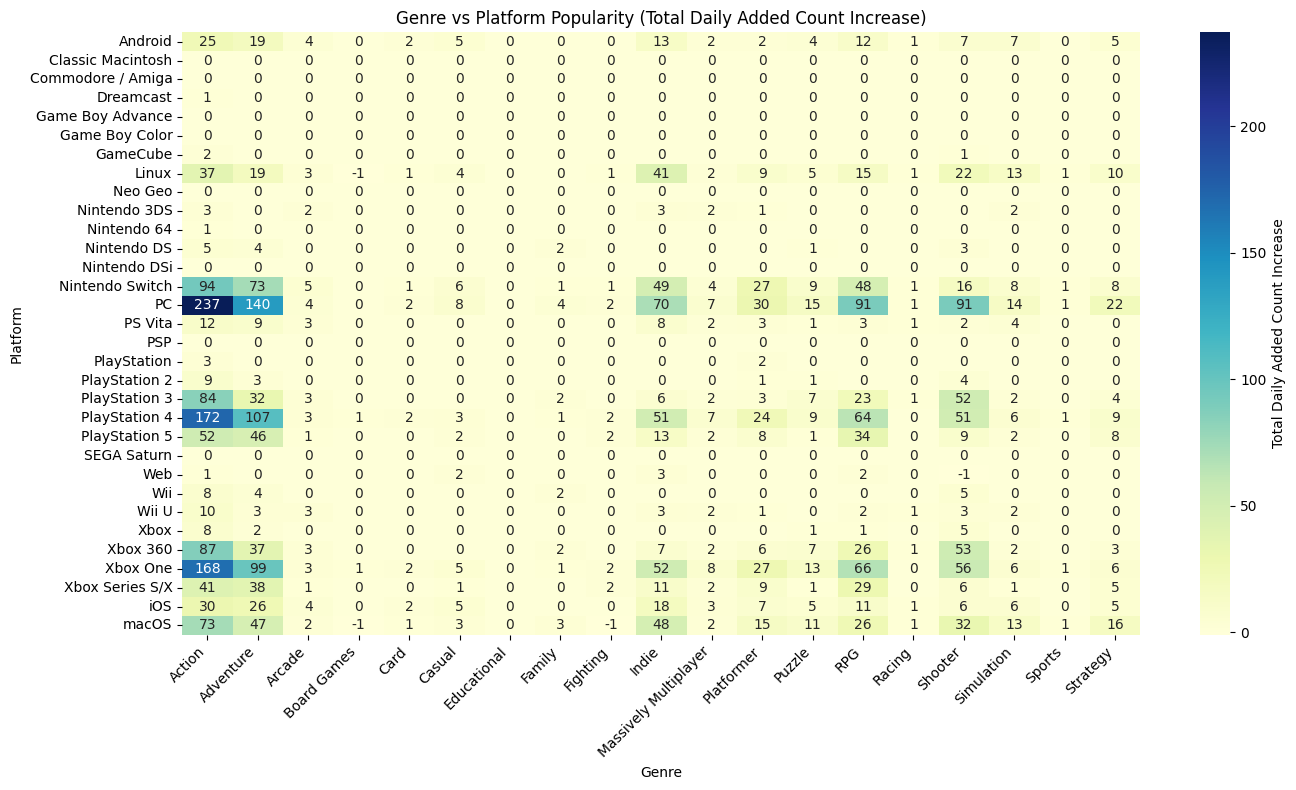

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure all_dfs is sorted by date
all_dfs = sorted(all_dfs, key=lambda df: df["date"].iloc[0])

cross_diffs = []

# Calculate daily differences and explode genres & platforms
for i in range(1, len(all_dfs)):
    today = all_dfs[i]
    yesterday = all_dfs[i-1]

    merged = pd.merge(
        today[["Name", "Added_Count", "Genres", "Platforms"]],
        yesterday[["Name", "Added_Count"]],
        on="Name",
        suffixes=("_today", "_yesterday"),
        how="inner"
    )

    # Daily difference
    merged["Added_Diff"] = merged["Added_Count_today"] - merged["Added_Count_yesterday"]

    # Explode both genres and platforms
    exploded = merged.explode("Genres").explode("Platforms")

    # Aggregate by platform and genre
    platform_genre_day = exploded.groupby(["Platforms", "Genres"])["Added_Diff"].sum().reset_index()
    platform_genre_day["date"] = today["date"].iloc[0]

    cross_diffs.append(platform_genre_day)

# Combine all days
cross_trends = pd.concat(cross_diffs)

# Pivot table: platforms as rows, genres as columns
pivot_df = cross_trends.pivot_table(
    index="Platforms",
    columns="Genres",
    values="Added_Diff",
    aggfunc="sum",
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Total Daily Added Count Increase'})
plt.title("Genre vs Platform Popularity (Total Daily Added Count Increase)")
plt.xlabel("Genre")
plt.ylabel("Platform")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
